# Lorenz Attractor

### Minimized entropy

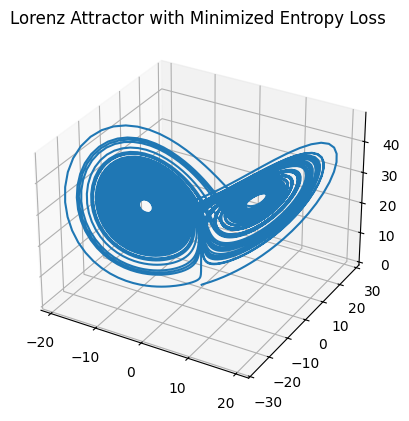

(None,
 np.float64(38.21588862828464),
 array([1.00005503e-01, 5.17649604e-06, 0.00000000e+00]))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Let's try something crazy: a chaotic system - the Lorenz attractor

# Lorenz system differential equations
def lorenz_system(state, sigma=10.0, rho=28.0, beta=8/3):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return np.array([dx, dy, dz])

# Simulate the Lorenz system
def simulate_lorenz(initial_state, dt=0.01, steps=10000):
    state = np.array(initial_state)
    trajectory = []
    for _ in range(steps):
        k1 = lorenz_system(state)
        k2 = lorenz_system(state + 0.5 * dt * k1)
        k3 = lorenz_system(state + 0.5 * dt * k2)
        k4 = lorenz_system(state + dt * k3)
        state += (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)
        trajectory.append(state.copy())
    return np.array(trajectory)

# Define *shannon* entropy over the 3D signal
def entropy_3d(signal):
    hist, _ = np.histogramdd(signal, bins=50, density=True)
    p = hist[hist > 0]
    return -np.sum(p * np.log(p))

# Define the entropy loss function
def entropy_loss_3d(signal):
    S = entropy_3d(signal)
    return 0.5 * S**2

# Objective function to tweak the initial conditions for minimum entropy
def objective_lorenz(initial_state):
    signal = simulate_lorenz(initial_state)
    return entropy_loss_3d(signal)

# Initial guess for Lorenz system starting point
initial_guess = [0.1, 0.0, 0.0]

# Optimize to find the initial state that minimizes entropy loss
result_lorenz = minimize(objective_lorenz, initial_guess, bounds=[(-30, 30), (-30, 30), (0, 50)])

# Simulate with optimized initial state
optimized_trajectory = simulate_lorenz(result_lorenz.x)

# Plot the optimized Lorenz attractor
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(optimized_trajectory[:, 0], optimized_trajectory[:, 1], optimized_trajectory[:, 2])
ax.set_title("Lorenz Attractor with Minimized Entropy Loss")
plt.show(), result_lorenz.fun, result_lorenz.x


### Maximized entropy

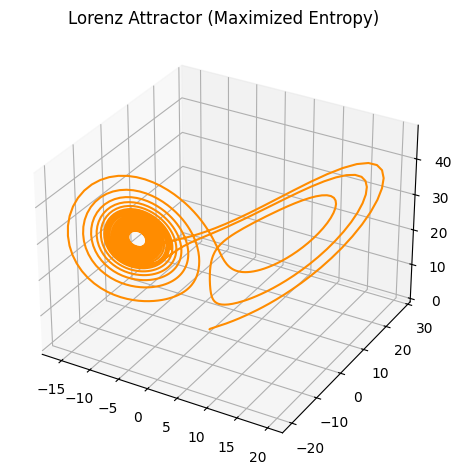

Final entropy: 2.0733167093587035
Initial state used: [0.10542652 0.0002838  0.        ]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import entropy


# Lorenz equations in NumPy
def lorenz_step(state, sigma=10.0, rho=28.0, beta=8/3):
    x, y, z = state[..., 0], state[..., 1], state[..., 2]
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return np.stack([dx, dy, dz], axis=-1)


# Runge-Kutta integration
def simulate_lorenz_np(initial_state, dt=0.01, steps=2000):
    state = np.array(initial_state)
    trajectory = np.zeros((steps, 3))
    for i in range(steps):
        k1 = lorenz_step(state)
        k2 = lorenz_step(state + 0.5 * dt * k1)
        k3 = lorenz_step(state + 0.5 * dt * k2)
        k4 = lorenz_step(state + dt * k3)
        state = state + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)
        trajectory[i] = state
    return trajectory

# Entropy estimation using histogram
def entropy_3d(signal, bins=30):
    hist, _ = np.histogramdd(signal, bins=bins, density=True)
    p = hist[hist > 0]
    return -np.sum(p * np.log(p))  # Shannon entropy

def entropy_loss(signal):
    S = entropy_3d(signal)
    return 0.5 * S**2

# Objective function for entropy maximization
def objective_entropy_max(initial_state):
    signal = simulate_lorenz_np(initial_state)
    return -entropy_loss(signal)  # Maximize entropy = minimize negative entropy

# Run optimization
initial_guess = [0.1, 0.0, 0.0]
result = minimize(objective_entropy_max, initial_guess, bounds=[(-30, 30), (-30, 30), (0, 50)], method='Nelder-Mead')

# Simulate and plot
final_traj = simulate_lorenz_np(result.x)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(final_traj[:, 0], final_traj[:, 1], final_traj[:, 2], color='darkorange')
ax.set_title("Lorenz Attractor (Maximized Entropy)")
plt.tight_layout()
plt.show()

print("Final entropy:", entropy_3d(final_traj))
print("Initial state used:", result.x)


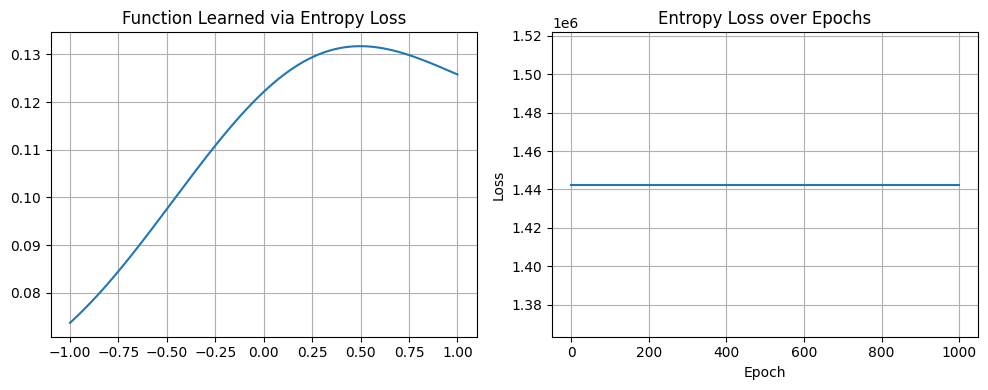


🧠 Neural Net Entropy Learning Summary
------------------------------------------------
Final Entropy Loss: 1442566.625000
Minimum Entropy Loss Reached: 1442566.625000
Maximum Entropy Loss Seen: 1442566.625000
Epochs Trained: 1000
Output Range: [0.0737, 0.1317]
Shape of Learned Function: (256, 1)
Sample Outputs:
[0.0737 0.0819 0.0918 0.1023 0.1126 0.1214 0.1278 0.1311 0.1316 0.1297
 0.1265]


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Use MPS if available, else fallback to CUDA or CPU
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")

# Input data: evenly spaced x values (no labels needed)
n_samples = 256
x = torch.linspace(-1, 1, n_samples, dtype=torch.float32).unsqueeze(1).to(device)

# Simple feedforward neural net
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

# Entropy loss function over predicted outputs
def entropy_loss(y_pred, bins=30):
    y = y_pred.detach().cpu().numpy().astype(np.float32).flatten()
    hist, _ = np.histogram(y, bins=bins, density=True)
    p = hist[hist > 0]
    entropy = -np.sum(p * np.log(p))
    return 0.5 * np.float32(entropy)**2

# Training
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 1000
loss_history = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)

    # Compute entropy loss (non-differentiable)
    loss_val = entropy_loss(y_pred)

    # Wrap as tensor with float32 to keep MPS happy
    loss = torch.tensor(loss_val, dtype=torch.float32, requires_grad=True, device=device)

    loss.backward()
    optimizer.step()
    loss_history.append(loss_val)

# Inference
model.eval()
with torch.no_grad():
    y_final = model(x).cpu().numpy()

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x.cpu().numpy(), y_final, label='NN Output')
plt.title("Function Learned via Entropy Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loss_history)
plt.title("Entropy Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Summary Printouts ---
print("\n🧠 Neural Net Entropy Learning Summary")
print("------------------------------------------------")
print(f"Final Entropy Loss: {loss_history[-1]:.6f}")
print(f"Minimum Entropy Loss Reached: {min(loss_history):.6f}")
print(f"Maximum Entropy Loss Seen: {max(loss_history):.6f}")
print(f"Epochs Trained: {epochs}")
print(f"Output Range: [{y_final.min():.4f}, {y_final.max():.4f}]")
print("Shape of Learned Function:", y_final.shape)
print("Sample Outputs:")
print(np.round(y_final.squeeze()[::len(y_final)//10], 4))  # print ~10 evenly spaced outputs


Running on device: mps
Epoch 1/24 | Entropy Loss: 12.264857 | Weighted Entropy Loss: 12.264857
Epoch 2/24 | Entropy Loss: 2.655023 | Weighted Entropy Loss: 2.655023
Epoch 3/24 | Entropy Loss: 2.215101 | Weighted Entropy Loss: 2.215101
Epoch 4/24 | Entropy Loss: 2.128021 | Weighted Entropy Loss: 2.128021
Epoch 5/24 | Entropy Loss: 2.198310 | Weighted Entropy Loss: -219.830902
Epoch 6/24 | Entropy Loss: 2.284695 | Weighted Entropy Loss: -228.469376
Epoch 7/24 | Entropy Loss: 2.367072 | Weighted Entropy Loss: -236.707016
Epoch 8/24 | Entropy Loss: 2.462425 | Weighted Entropy Loss: -246.242371
Epoch 9/24 | Entropy Loss: 2.562318 | Weighted Entropy Loss: 2.562318
Epoch 10/24 | Entropy Loss: 2.643002 | Weighted Entropy Loss: 2.643002
Epoch 11/24 | Entropy Loss: 2.737854 | Weighted Entropy Loss: 2.737854
Epoch 12/24 | Entropy Loss: 2.810555 | Weighted Entropy Loss: 2.810555
Epoch 13/24 | Entropy Loss: 2.884732 | Weighted Entropy Loss: -288.473114
Epoch 14/24 | Entropy Loss: 2.945887 | Weighte

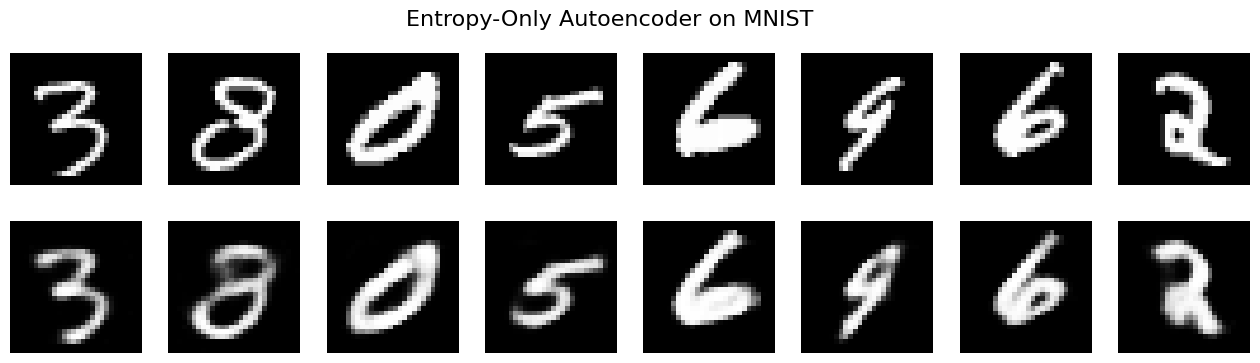

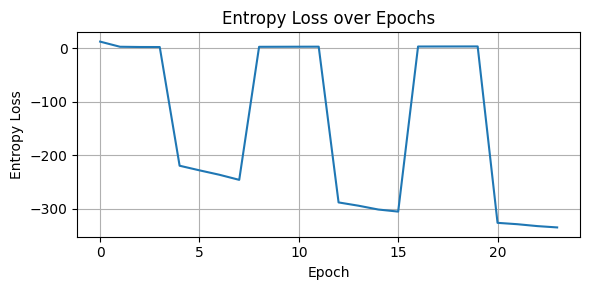

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# --- Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")
print("Running on device:", device)

# --- Hyperparameters
latent_dim = 16
batch_size = 128
epochs = 24
lr = 1e-3

# --- Load MNIST (unsupervised)
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# --- Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return z, out

# --- Entropy loss over latent activations
def entropy_loss(z, bins=30):
    z_np = z.detach().cpu().numpy().flatten()
    hist, _ = np.histogram(z_np, bins=bins, density=True)
    p = hist[hist > 0]
    S = -np.sum(p * np.log(p))
    return 0.5 * np.float32(S)**2

# --- Training
model = Autoencoder(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_history = []

for epoch in range(epochs):
    model.train()
    
    ent_loss = 0.0
    weighted_ent_loss = 0.0
    
    if (epoch // 4) % 2 == 0:
        flip = 1
    else:
        flip = -100  # aggressive exploration phase
        
    for batch in train_loader:
        x, _ = batch
        x = x.to(device)
        optimizer.zero_grad()

        z, x_recon = model(x)

        entropy_val = entropy_loss(z)
        recon_loss = nn.MSELoss()(x_recon, x)
        
        loss = flip * entropy_val + 0.001 * recon_loss

        loss.backward()
        optimizer.step()

        ent_loss += entropy_val
        weighted_ent_loss += flip * entropy_val

    avg_entropy_loss = ent_loss / len(train_loader)
    avg_weighted_loss = weighted_ent_loss / len(train_loader)
    loss_history.append(avg_weighted_loss)

    print(f"Epoch {epoch+1}/{epochs} | Entropy Loss: {avg_entropy_loss:.6f} | Weighted Entropy Loss: {avg_weighted_loss:.6f}")


# --- Visualize Reconstructions
model.eval()
sample_batch, _ = next(iter(train_loader))
sample_batch = sample_batch[:8].to(device)
with torch.no_grad():
    z, recon = model(sample_batch)

sample_batch = sample_batch.cpu()
recon = recon.cpu()

fig, axs = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axs[0, i].imshow(sample_batch[i][0], cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(recon[i][0], cmap='gray')
    axs[1, i].axis('off')
axs[0, 0].set_ylabel("Original", fontsize=14)
axs[1, 0].set_ylabel("Reconstruction", fontsize=14)
plt.suptitle("Entropy-Only Autoencoder on MNIST", fontsize=16)
plt.show()

# --- Plot loss over epochs
plt.figure(figsize=(6, 3))
plt.plot(loss_history)
plt.title("Entropy Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Entropy Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


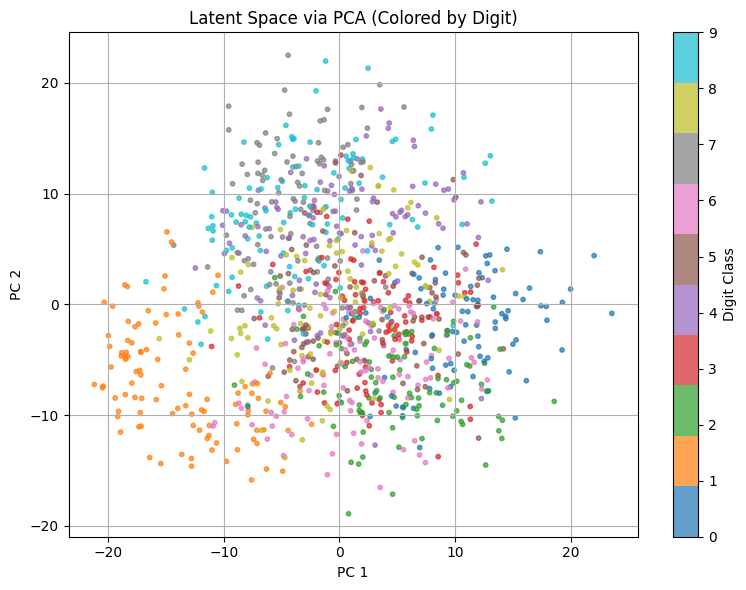

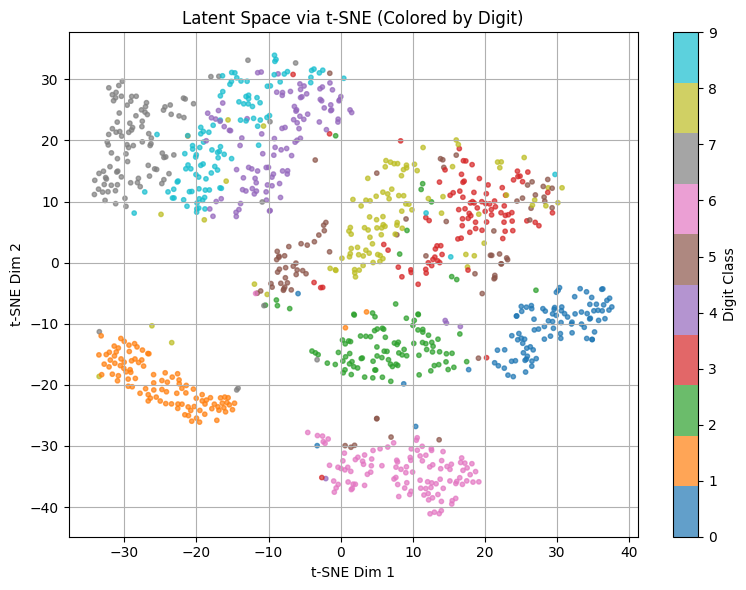

In [32]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# --- Grab a sample batch (with labels this time)
model.eval()
sample_batch, labels = next(iter(DataLoader(train_data, batch_size=1000, shuffle=True)))
sample_batch = sample_batch.to(device)

with torch.no_grad():
    z, _ = model(sample_batch)

z_np = z.cpu().numpy()
labels = labels.numpy()

# --- Use PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_np)

# --- Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=labels, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label="Digit Class")
plt.title("Latent Space via PCA (Colored by Digit)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.tight_layout()
plt.show()


from sklearn.manifold import TSNE

# --- Apply t-SNE to the same latent space used in PCA
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
z_tsne = tsne.fit_transform(z_np)

# --- Plot t-SNE results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label="Digit Class")
plt.title("Latent Space via t-SNE (Colored by Digit)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)
plt.tight_layout()
plt.show()
